In [1]:
import os
import numpy as np
import pandas as pd
import time
import glob
import pathlib
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from statistics import mean 
from tqdm import tqdm
from plotnine import *
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error

import sys
sys.path.append("/tf/vggish")

import vggish_params 
import vggish_input
import mel_features

seed = 27
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200

BATCH_SIZE=32
DROPOUT=0.3
LEARNING_RATE=0.001
CLASSIFICATION_RATIO=0.999

In [4]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [5]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()
meta.Gender = meta.Gender.str.strip()

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
size_sec = 30
stride_sec = 1

In [22]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    mmse = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    group = tf.gather(meta.Group.map({'cc': 0, 'cd': 1}), tf.where(tf.equal(names, name))[0][0])
    
    age = tf.gather(meta.Age, tf.where(tf.equal(names, name))[0][0])
    gender = tf.gather(meta.Gender.map({'male': 0, 'female': 1}), tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=int(_*size_sec), stride=int(_*stride_sec))
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, mmse/30, group #, age, gender

In [23]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda spec, mmse, group: tf.data.Dataset.zip((
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices(spec)
#                                         tf.data.Dataset.from_tensor_slices([age]),
#                                         tf.data.Dataset.from_tensor_slices([gender]),
                                    )),
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices([mmse]), 
                                        tf.data.Dataset.from_tensor_slices([group]) 
                                    ))
                                )))\
                        .shuffle(100)
    return output_ds

In [24]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [25]:
for input, output in train_ds.take(1):
    input_shape = input.shape
    print(input_shape)
#     print(input[1])
#     print(input[2])
    print(output[0])
    print(output[1])


(30, 257, 1)
tf.Tensor(0.4666666666666667, shape=(), dtype=float64)
tf.Tensor(1, shape=(), dtype=int64)


In [177]:
BATCH_SIZE=64
train_ds_b = train_ds.batch(BATCH_SIZE)
val_ds_b = val_ds.batch(BATCH_SIZE)

In [178]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

In [212]:
specInput = layers.Input(shape=input_shape)
reshapeSpecInput = layers.Reshape((input_shape[0],input_shape[1]))(specInput)
normSpec = norm_layer(reshapeSpecInput)

# ageInput = layers.Input(shape=(1,))
# genderInput = layers.Input(shape=(1,))


dense1 = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(normSpec)
dropout1 = layers.Dropout(0.25)(dense1)
lstm1 = layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True)(dropout1)
dropout2 = layers.Dropout(0.25)(lstm1)
lstm2 = layers.LSTM(64, activation='relu', kernel_initializer='he_normal')(dropout2)
dropout3 = layers.Dropout(0.25)(lstm2)

# concat = tf.keras.layers.Concatenate()([dropout3, ageInput, genderInput])

dense2 = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout3) #concat
dropout4 = layers.Dropout(0.25)(dense2)

mmseDense = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout4)
mmse = layers.Dense(1, activation='relu', kernel_initializer='he_normal', name='mmse')(mmseDense)

classificationDense = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout4)
classification = layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal', name='classification')(classificationDense)

model = tf.keras.Model(
    inputs=specInput,
    outputs=[mmse, classification],
)

print(model.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30, 257, 1)] 0                                            
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 30, 257)      0           input_11[0][0]                   
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 30, 257)      3           reshape_10[0][0]                 
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 30, 256)      66048       normalization_3[4][0]            
___________________________________________________________________________________________

In [213]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1),
    loss = ['mse','binary_crossentropy'],
    loss_weights=[1, 0.1]
)

In [214]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=LEARNING_RATE))

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True)

history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=es_callback,  #[lr_callback, 
    verbose = 2
)

Epoch 1/1000
2/2 - 2s - loss: 1657.0570 - mmse_loss: 1656.5442 - classification_loss: 5.1277 - val_loss: 372.1454 - val_mmse_loss: 371.6108 - val_classification_loss: 5.3455
Epoch 2/1000
2/2 - 1s - loss: 254.2828 - mmse_loss: 253.9449 - classification_loss: 3.3787 - val_loss: 1537.4041 - val_mmse_loss: 1536.3420 - val_classification_loss: 10.6205
Epoch 3/1000
2/2 - 0s - loss: 1269.4878 - mmse_loss: 1268.6298 - classification_loss: 8.5803 - val_loss: 1268.3956 - val_mmse_loss: 1267.0006 - val_classification_loss: 13.9508
Epoch 4/1000
2/2 - 0s - loss: 1703.4122 - mmse_loss: 1702.7465 - classification_loss: 6.6579 - val_loss: 359.0197 - val_mmse_loss: 358.0494 - val_classification_loss: 9.7027
Epoch 5/1000
2/2 - 0s - loss: 1620.9769 - mmse_loss: 1620.0278 - classification_loss: 9.4915 - val_loss: 34.5750 - val_mmse_loss: 34.3382 - val_classification_loss: 2.3675
Epoch 6/1000
2/2 - 0s - loss: 302.4853 - mmse_loss: 302.2672 - classification_loss: 2.1805 - val_loss: 23.9679 - val_mmse_loss: 

Epoch 51/1000
2/2 - 0s - loss: 0.1849 - mmse_loss: 0.1160 - classification_loss: 0.6887 - val_loss: 0.2216 - val_mmse_loss: 0.1500 - val_classification_loss: 0.7164
Epoch 52/1000
2/2 - 0s - loss: 0.1760 - mmse_loss: 0.1074 - classification_loss: 0.6861 - val_loss: 0.2036 - val_mmse_loss: 0.1327 - val_classification_loss: 0.7083
Epoch 53/1000
2/2 - 0s - loss: 0.1665 - mmse_loss: 0.0920 - classification_loss: 0.7456 - val_loss: 0.1860 - val_mmse_loss: 0.1157 - val_classification_loss: 0.7029
Epoch 54/1000
2/2 - 0s - loss: 0.1917 - mmse_loss: 0.1221 - classification_loss: 0.6958 - val_loss: 0.2077 - val_mmse_loss: 0.1380 - val_classification_loss: 0.6966
Epoch 55/1000
2/2 - 0s - loss: 0.1856 - mmse_loss: 0.1126 - classification_loss: 0.7294 - val_loss: 0.2174 - val_mmse_loss: 0.1479 - val_classification_loss: 0.6950
Epoch 56/1000
2/2 - 0s - loss: 0.1903 - mmse_loss: 0.1210 - classification_loss: 0.6929 - val_loss: 0.2418 - val_mmse_loss: 0.1730 - val_classification_loss: 0.6876
Epoch 57/1

Epoch 101/1000
2/2 - 0s - loss: 0.1484 - mmse_loss: 0.0825 - classification_loss: 0.6591 - val_loss: 0.1634 - val_mmse_loss: 0.0972 - val_classification_loss: 0.6620
Epoch 102/1000
2/2 - 0s - loss: 0.1591 - mmse_loss: 0.0894 - classification_loss: 0.6967 - val_loss: 0.1793 - val_mmse_loss: 0.1130 - val_classification_loss: 0.6624
Epoch 103/1000
2/2 - 0s - loss: 0.1573 - mmse_loss: 0.0874 - classification_loss: 0.6993 - val_loss: 0.1805 - val_mmse_loss: 0.1146 - val_classification_loss: 0.6594
Epoch 104/1000
2/2 - 0s - loss: 0.1431 - mmse_loss: 0.0745 - classification_loss: 0.6866 - val_loss: 0.1711 - val_mmse_loss: 0.1055 - val_classification_loss: 0.6553
Epoch 105/1000
2/2 - 0s - loss: 0.1345 - mmse_loss: 0.0668 - classification_loss: 0.6770 - val_loss: 0.1551 - val_mmse_loss: 0.0899 - val_classification_loss: 0.6513
Epoch 106/1000
2/2 - 0s - loss: 0.1405 - mmse_loss: 0.0722 - classification_loss: 0.6831 - val_loss: 0.1389 - val_mmse_loss: 0.0740 - val_classification_loss: 0.6488
Epoc

Epoch 151/1000
2/2 - 0s - loss: 0.1149 - mmse_loss: 0.0503 - classification_loss: 0.6457 - val_loss: 0.1958 - val_mmse_loss: 0.1314 - val_classification_loss: 0.6448
Epoch 152/1000
2/2 - 0s - loss: 0.1151 - mmse_loss: 0.0509 - classification_loss: 0.6426 - val_loss: 0.1758 - val_mmse_loss: 0.1116 - val_classification_loss: 0.6421
Epoch 153/1000
2/2 - 0s - loss: 0.1274 - mmse_loss: 0.0623 - classification_loss: 0.6509 - val_loss: 0.1712 - val_mmse_loss: 0.1071 - val_classification_loss: 0.6406
Epoch 154/1000
2/2 - 0s - loss: 0.1713 - mmse_loss: 0.1052 - classification_loss: 0.6609 - val_loss: 0.1911 - val_mmse_loss: 0.1267 - val_classification_loss: 0.6444
Epoch 155/1000
2/2 - 0s - loss: 0.1134 - mmse_loss: 0.0466 - classification_loss: 0.6677 - val_loss: 0.1930 - val_mmse_loss: 0.1286 - val_classification_loss: 0.6434
Epoch 156/1000
2/2 - 0s - loss: 0.1241 - mmse_loss: 0.0556 - classification_loss: 0.6852 - val_loss: 0.1852 - val_mmse_loss: 0.1213 - val_classification_loss: 0.6394
Epoc

Epoch 201/1000
2/2 - 0s - loss: 0.1102 - mmse_loss: 0.0448 - classification_loss: 0.6538 - val_loss: 0.1555 - val_mmse_loss: 0.0928 - val_classification_loss: 0.6275
Epoch 202/1000
2/2 - 0s - loss: 0.1084 - mmse_loss: 0.0479 - classification_loss: 0.6048 - val_loss: 0.1538 - val_mmse_loss: 0.0913 - val_classification_loss: 0.6250
Epoch 203/1000
2/2 - 0s - loss: 0.1132 - mmse_loss: 0.0515 - classification_loss: 0.6172 - val_loss: 0.1680 - val_mmse_loss: 0.1055 - val_classification_loss: 0.6257
Epoch 204/1000
2/2 - 0s - loss: 0.1267 - mmse_loss: 0.0660 - classification_loss: 0.6074 - val_loss: 0.1998 - val_mmse_loss: 0.1365 - val_classification_loss: 0.6330
Epoch 205/1000
2/2 - 0s - loss: 0.1223 - mmse_loss: 0.0589 - classification_loss: 0.6339 - val_loss: 0.2238 - val_mmse_loss: 0.1597 - val_classification_loss: 0.6410
Epoch 206/1000
2/2 - 0s - loss: 0.1069 - mmse_loss: 0.0434 - classification_loss: 0.6348 - val_loss: 0.2194 - val_mmse_loss: 0.1554 - val_classification_loss: 0.6399
Epoc

Epoch 251/1000
2/2 - 0s - loss: 0.0818 - mmse_loss: 0.0279 - classification_loss: 0.5391 - val_loss: 0.1903 - val_mmse_loss: 0.1242 - val_classification_loss: 0.6611
Epoch 252/1000
2/2 - 0s - loss: 0.0960 - mmse_loss: 0.0406 - classification_loss: 0.5543 - val_loss: 0.2005 - val_mmse_loss: 0.1339 - val_classification_loss: 0.6661
Epoch 253/1000
2/2 - 0s - loss: 0.0914 - mmse_loss: 0.0344 - classification_loss: 0.5704 - val_loss: 0.2256 - val_mmse_loss: 0.1584 - val_classification_loss: 0.6725
Epoch 254/1000
2/2 - 0s - loss: 0.0990 - mmse_loss: 0.0440 - classification_loss: 0.5496 - val_loss: 0.2427 - val_mmse_loss: 0.1747 - val_classification_loss: 0.6803
Epoch 255/1000
2/2 - 0s - loss: 0.0978 - mmse_loss: 0.0426 - classification_loss: 0.5517 - val_loss: 0.2270 - val_mmse_loss: 0.1589 - val_classification_loss: 0.6808
Epoch 256/1000
2/2 - 0s - loss: 0.0952 - mmse_loss: 0.0416 - classification_loss: 0.5362 - val_loss: 0.1960 - val_mmse_loss: 0.1292 - val_classification_loss: 0.6675
Epoc

Epoch 301/1000
2/2 - 0s - loss: 0.0852 - mmse_loss: 0.0366 - classification_loss: 0.4859 - val_loss: 0.2140 - val_mmse_loss: 0.1525 - val_classification_loss: 0.6153
Epoch 302/1000
2/2 - 0s - loss: 0.0879 - mmse_loss: 0.0373 - classification_loss: 0.5059 - val_loss: 0.1987 - val_mmse_loss: 0.1375 - val_classification_loss: 0.6121
Epoch 303/1000
2/2 - 0s - loss: 0.0775 - mmse_loss: 0.0302 - classification_loss: 0.4732 - val_loss: 0.1844 - val_mmse_loss: 0.1235 - val_classification_loss: 0.6093
Epoch 304/1000
2/2 - 0s - loss: 0.0803 - mmse_loss: 0.0286 - classification_loss: 0.5168 - val_loss: 0.1796 - val_mmse_loss: 0.1189 - val_classification_loss: 0.6077
Epoch 305/1000
2/2 - 0s - loss: 0.0734 - mmse_loss: 0.0271 - classification_loss: 0.4629 - val_loss: 0.1992 - val_mmse_loss: 0.1376 - val_classification_loss: 0.6160
Epoch 306/1000
2/2 - 0s - loss: 0.0844 - mmse_loss: 0.0365 - classification_loss: 0.4792 - val_loss: 0.2063 - val_mmse_loss: 0.1446 - val_classification_loss: 0.6174
Epoc

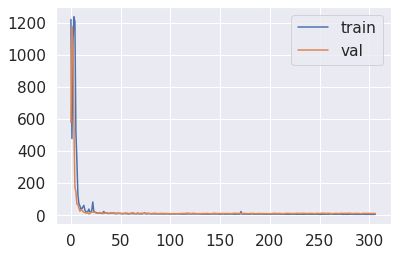

In [217]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mmse_loss']) * 30, np.sqrt(metrics['val_mmse_loss']) * 30)
plt.legend(['train', 'val'])
plt.show()

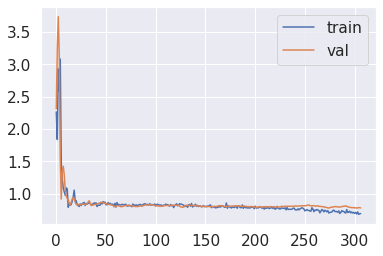

In [218]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['classification_loss']), np.sqrt(metrics['val_classification_loss']))
plt.legend(['train', 'val'])
plt.show()

In [219]:
meta = meta.assign(split = '', predict_mmse = -99.99, predict_group_prob = 0)

def applyModelStats(file, split_type):
    
    id = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    
    meta.loc[meta["ID"]==id,'split'] = split_type
    predict = model.predict(get_data(file)[0])
    
    mmse = mean(predict[0].flatten()) * 30
    group_prob = mean(predict[1].flatten())
    predict_group = 'cd' if group_prob > 0.5 else 'cc'
    
#     median_predict = np.percentile(predict[0].flatten()[0], 50)   
#     predict25 = np.percentile(predict[0].flatten()[0], 25)   
#     predict75 = np.percentile(predict[0].flatten()[0], 75)   
    
#     avg_predict_group_prob = np.median(predict[1][:,0])
#     std_predict_group_prob = np.std(predict[1][:,0])
    
    meta.loc[meta["ID"]==id,'predict_mmse'] = mmse    
    meta.loc[meta["ID"]==id,'predict_group_prob'] = group_prob
    meta.loc[meta["ID"]==id,'predict_group'] = predict_group


for file in train_files:
    applyModelStats(file, "train")
    
for file in val_files:
    applyModelStats(file, "val")
    
for file in test_files:
    applyModelStats(file, "test")

In [220]:
meta

,index,ID,Age,Gender,MMSE,Group,split,predict_mmse,predict_group_prob,predict_group
0,0,S001,74,male,30,cc,val,20.705704,0.407075,cc
1,1,S002,62,female,30,cc,train,19.125767,0.484847,cc
2,2,S003,69,female,29,cc,train,20.563112,0.420607,cc
3,3,S004,71,female,30,cc,train,22.202595,0.400678,cc
4,4,S005,74,female,30,cc,train,19.083654,0.480727,cc
...,...,...,...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,test,28.087351,0.314872,cc
104,50,S151,72,male,24,cd,val,20.103647,0.409220,cc
105,51,S153,68,female,12,cd,train,14.866094,0.454517,cc
106,52,S154,65,female,20,cd,train,16.724870,0.460362,cc


In [221]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict_mmse'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,6.890871
1,train,8.049758
2,val,8.361372


In [222]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,7.892753
1,male,7.968679


In [223]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict_mmse'] ))

7.926587397349082

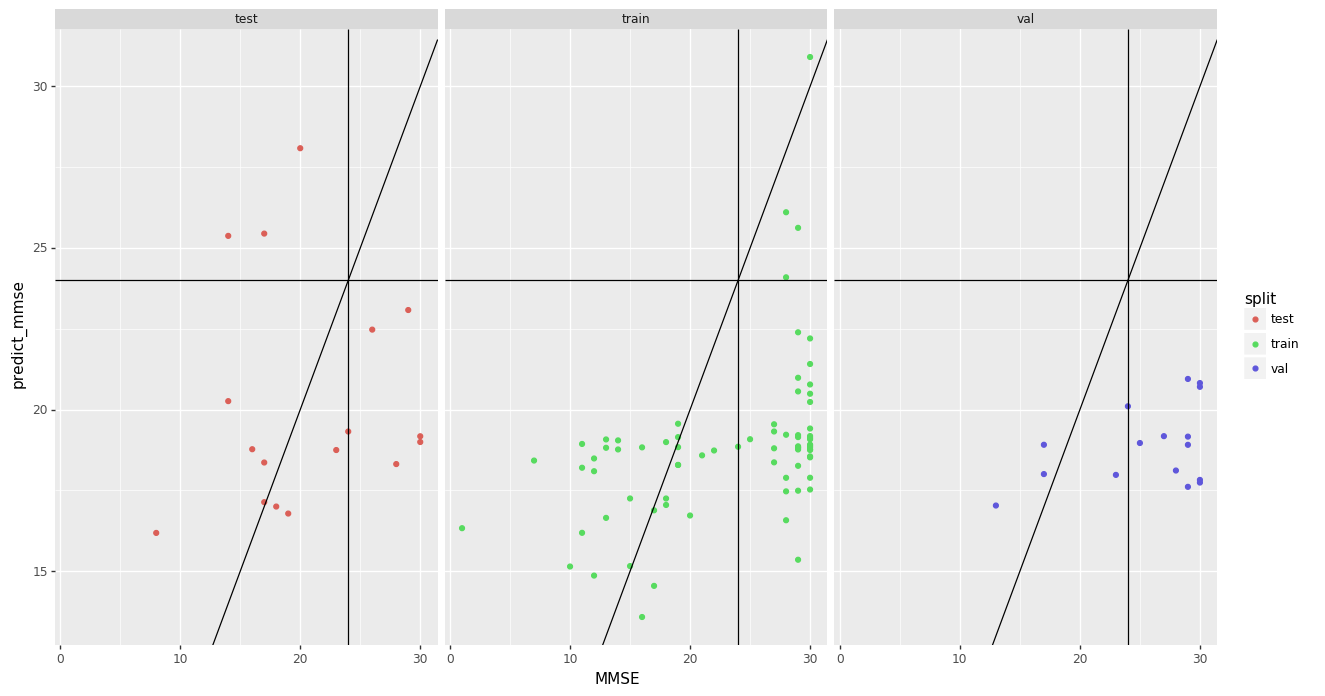

<ggplot: (8794662924664)>

In [224]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict_mmse', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

Logistic: ROC AUC = 0.721


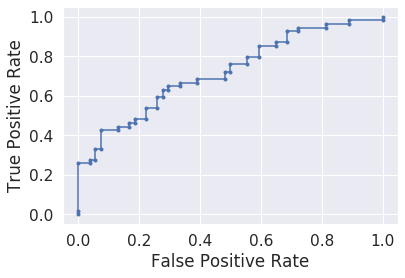

In [207]:
y = meta.Group.apply(lambda x: 1 if x=="cd" else 0)
probs = meta.predict_group_prob

lr_auc = roc_auc_score(y, probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()

In [208]:
# model.save('saved_model/base_line/20210222')

In [209]:
ls saved_model/base_line

20210210/  20210217/  20210222/  20210225/


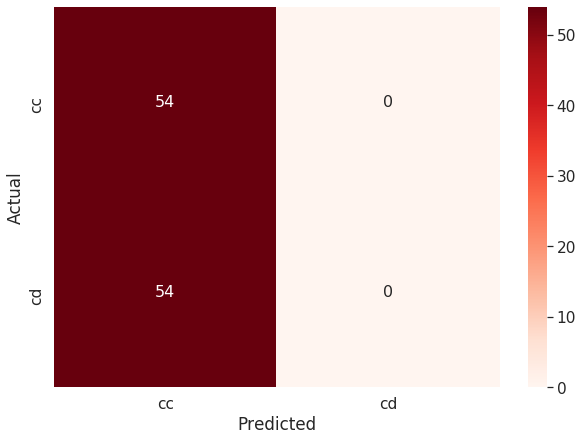

In [210]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [211]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          cc       0.50      1.00      0.67        54
          cd       0.00      0.00      0.00        54

    accuracy                           0.50       108
   macro avg       0.25      0.50      0.33       108
weighted avg       0.25      0.50      0.33       108



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Pitts Corpus

In [92]:
data_path_pitt = '/tf/data/dementia/English/Pitt/'
files_pitt = tf.io.gfile.glob(data_path_pitt + 'Control/cookie/*.wav') + \
             tf.io.gfile.glob(data_path_pitt + 'Dementia/cookie/*.wav')

In [98]:
input_file = files_pitt[0]

In [99]:
input_file

'/tf/data/dementia/English/Pitt/Control/cookie/255-1.wav'

In [94]:
def model_inference(filepath):

    import tensorflow as tf
    import numpy as np
    import json
    import requests	
    import os
    from datetime import datetime
    
    input_file = filepath
    if not filepath.lower().endswith(".wav"):
#         tmp_name = "tmp-"+datetime.now().strftime("%Y%m%d-%H%M%S")
        input_file = input_file.split('.mp3')[0] + '.wav'
        cmd = "ffmpeg -i " + filepath + " " + input_file
        os.system(cmd)
    
    audio_binary = tf.io.read_file(input_file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    if audio.shape[1] > 1:
        audio = tf.reshape(audio[:, 0], (audio.shape[0],1))

    waveform = tf.squeeze(audio, axis=-1)    
    rolling_waveform_tensors = window(waveform, size=_*30, stride=_*1)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
    rolling_spectrograms = rolling_spectrograms.numpy().tolist()
    
    predictions = model.predict(rolling_spectrograms)
    results = [x[0] for x in predictions]
    result = sum(results)/len(results) * 30

#     os.system('rm ' + input_file)
    return result, results

In [97]:
meta_pitt = pd.DataFrame(columns= ['file', 'ID', 'Group', 'MMSE', 'predict', 'predict_group', 'predicts'])
for file in tqdm(files_pitt):
    print(file)
    ID = file.split('/')[-1].split('.')[0]
    Group = file.split('/')[6]
    cha = pd.read_fwf(data_path_pitt + 'Pitt/' + Group + '/cookie/' + ID + '.cha')  
    cha_id = [x for x in cha['@UTF8'] if str.startswith(x, '@ID:')][0]
    
    if (cha_id.split('|')[-3] == ''):
        MMSE = np.NaN
    else:
        MMSE = int(cha_id.split('|')[-3])
        
    predict, predicts = model_inference(file)
    if (predict < 24):
        predict_group = 'Dementia'
    else:
        predict_group = 'Control'
    meta_pitt = meta_pitt.append(pd.DataFrame([[file, ID, Group, MMSE, predict, predict_group, predicts]], 
                                  columns = list(meta_pitt.columns)))

  0%|          | 0/552 [00:00<?, ?it/s]

/tf/data/dementia/English/Pitt/Control/cookie/255-1.wav


  0%|          | 0/552 [00:00<?, ?it/s]


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:207 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_7 expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 30, 257, 1) dtype=float32>]


In [294]:
meta_pitt['predict_min'] = [min(x) for x in meta_pitt.predicts]
meta_pitt['predict_group_min'] = ['Control' if x >= 24 else 'Dementia' for x in meta_pitt.predict_min]

In [295]:
meta_pitt_eval = meta_pitt[meta_pitt.MMSE.notna()]

In [296]:
meta_pitt.shape

(552, 9)

In [297]:
meta_pitt_eval.shape

(457, 9)

In [298]:
meta_pitt_eval.head()

,file,ID,Group,MMSE,predict,predict_group,predicts,predict_min,predict_group_min
0,/tf/data/dementia/English/Pitt/Control/cookie/...,128-3,Control,29,25.855359,Control,"[0.8192363, 0.80515444, 0.8759565, 0.9246044, ...",0.482245,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,229-2,Control,30,16.437099,Dementia,"[0.5487453, 0.54861814, 0.5485862, 0.54736215,...",0.546205,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,196-0,Control,28,20.300190,Dementia,"[0.6018041, 0.6044841, 0.61234003, 0.6232815, ...",0.601804,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,668-0,Control,29,18.987910,Dementia,"[0.8942066, 0.91020316, 0.94213617, 0.96051204...",0.379110,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,073-1,Control,29,17.749986,Dementia,"[0.5269004, 0.52823627, 0.52713543, 0.5275847,...",0.526900,Dementia


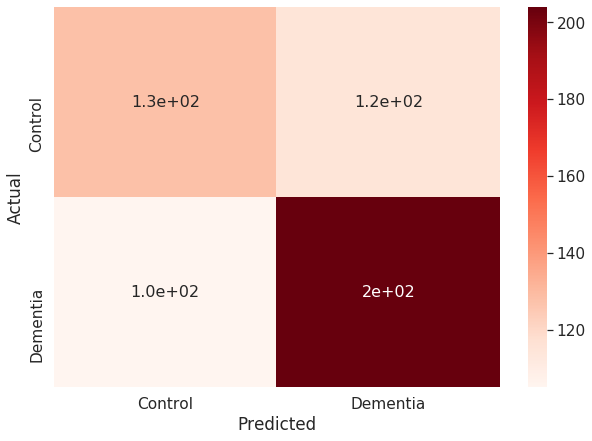

In [299]:
y_true = meta_pitt.Group
y_pred = meta_pitt.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16})# font size

In [300]:
df_cm

Predicted,Control,Dementia
Actual,,
Control,128,115
Dementia,105,204


In [301]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     Control       0.55      0.53      0.54       243
    Dementia       0.64      0.66      0.65       309

    accuracy                           0.60       552
   macro avg       0.59      0.59      0.59       552
weighted avg       0.60      0.60      0.60       552



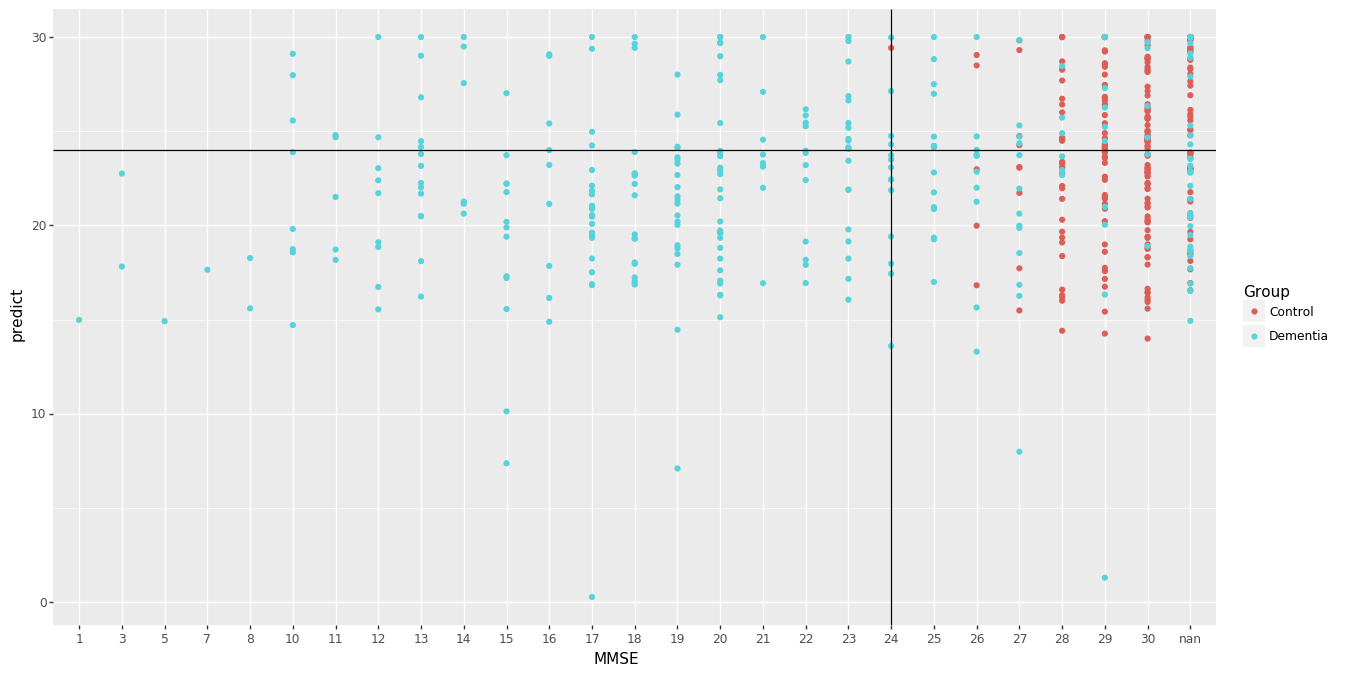

<ggplot: (8780796494600)>

In [310]:
ggplot(meta_pitt) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'Group')) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 20, lty = 2)) + \
theme(figure_size = (15, 8))